In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

## ABOUT THE QUESTIONS

This notebook's aim is to provide solutions for the **5th** and **6th** question. Here are the problems:
- Which **provinces in Vietnam** have the most storms and floods in a year? Calculated based on the last 3 years.
- Can we construct a **machine learning classifier** to automatically determine the **severity level** of a disaster event based on multi-dimensional indicators?

> ## QUESTION 5: 
> Which **provinces in Vietnam** have the most storms and floods in a year? Calculated based on the last 3 years.

For this question, we don't need complicated preprocessing steps. Instead of that, we will filter out the necessary features as below:


In [108]:
# Đọc dữ liệu từ file Excel
df = pd.read_excel('..\data\disaster_sea.xlsx')

# Lọc dữ liệu chỉ cho Việt Nam dựa trên mã ISO
df_vietnam = df[df['ISO'] == 'VNM']

# Đảm bảo các cột ngày, tháng, năm có mặt
if {'Start Year', 'Start Month', 'Start Day'}.issubset(df_vietnam.columns):
    # Chuyển đổi cột thời gian thành định dạng datetime
    df_vietnam['Start Date'] = pd.to_datetime(df_vietnam[['Start Year', 'Start Month', 'Start Day']].astype(str).agg('-'.join, axis=1), errors='coerce')

    # Lọc dữ liệu của ba năm gần nhất
    current_year = pd.Timestamp.now().year
    df_recent_vietnam = df_vietnam[df_vietnam['Start Year'] >= (current_year - 3)]

    # Lọc các thảm họa là bão và lũ lụt
    df_storms_floods = df_recent_vietnam[(df_recent_vietnam['Disaster Type'] == 'Storm') | (df_recent_vietnam['Disaster Type'] == 'Flood')]

    # Nhóm theo tỉnh và đếm số lần xuất hiện của bão và lũ lụt
    province_counts = df_storms_floods['Location'].value_counts()

    # Chuyển kết quả thành DataFrame
    df_province_counts = province_counts.reset_index()
    df_province_counts.columns = ['Location', 'Count']

    # In kết quả
    print(df_province_counts)
else:
    print("Các cột 'Start Year', 'Start Month', và 'Start Day' không tồn tại trong dataframe.")

                                             Location  Count
0   Minh Luong Commune, Viet Tien (Van Ban Distric...      1
1               Thai Binh, Ha Nam, Nam Dinh provinces      1
2   Dien Bien, Lao Cai, Ha Giang, Yen Bai, Cao Ban...      1
3   Lao Cai, Yen Bai, Thai Nguyen, Phu Tho, Quang ...      1
4   Lao Cai, Yen Bai, Ha Giang, Cao Bang, Bac Kan,...      1
5    Quang Tri, Thua Thien Hue and Ha Tinh Provinces       1
6       Yen Bai, Thai Nguyen et Tuyen Quang provinces      1
7   Lai Chau, Yen Bai, Son La, Lao Cai, Dien Bien,...      1
8   Lam Dong Province (central Vietnam), Binh Thua...      1
9                                 Kien Giang Province      1
10  Cao Bang, Lao Cai, Yen Bai, Phu Tho, Dien Bien...      1
11  Quang Nam, Quang Tri, Phu Yen, Phu Loc distric...      1
12  Thua Thien Hue, Quang Tri, Quang Binh and Da N...      1
13  Nghia Hanh and Duc Pho Districts (Quang Ngai p...      1
14  Quang Ngai, Quang Tri, Thua Thien, Hue, Da Nan...      1
15                      

C:\Users\ACER\AppData\Local\Temp\ipykernel_30608\2502343901.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_vietnam['Start Date'] = pd.to_datetime(df_vietnam[['Start Year', 'Start Month', 'Start Day']].astype(str).agg('-'.join, axis=1), errors='coerce')
C:\Users\ACER\AppData\Local\Temp\ipykernel_30608\2502343901.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vietnam['Start Date'] = pd.to_datetime(df_vietnam[['Start Year', 'Start Month', 'Start Day']].astype(str).agg('-'.join, axis=1), errors='coerce')


In [109]:
df_province_counts['Location']

0     Minh Luong Commune, Viet Tien (Van Ban Distric...
1                 Thai Binh, Ha Nam, Nam Dinh provinces
2     Dien Bien, Lao Cai, Ha Giang, Yen Bai, Cao Ban...
3     Lao Cai, Yen Bai, Thai Nguyen, Phu Tho, Quang ...
4     Lao Cai, Yen Bai, Ha Giang, Cao Bang, Bac Kan,...
5      Quang Tri, Thua Thien Hue and Ha Tinh Provinces 
6         Yen Bai, Thai Nguyen et Tuyen Quang provinces
7     Lai Chau, Yen Bai, Son La, Lao Cai, Dien Bien,...
8     Lam Dong Province (central Vietnam), Binh Thua...
9                                   Kien Giang Province
10    Cao Bang, Lao Cai, Yen Bai, Phu Tho, Dien Bien...
11    Quang Nam, Quang Tri, Phu Yen, Phu Loc distric...
12    Thua Thien Hue, Quang Tri, Quang Binh and Da N...
13    Nghia Hanh and Duc Pho Districts (Quang Ngai p...
14    Quang Ngai, Quang Tri, Thua Thien, Hue, Da Nan...
15                                              Dak Lak
16    Tuyen Quang, Hoa Binh, Dien Bien, Cao Bang, Vi...
17    Cao Bang, Yen Bai, Lang Son, Quang Ninh, H

In [110]:
import unidecode

# Danh sách các tỉnh của Việt Nam với chữ cái đầu viết hoa, không dấu
vietnam_provinces = [
    'An Giang', 'Ba Ria - Vung Tau', 'Bac Giang', 'Bac Kan', 'Bac Lieu', 
    'Bac Ninh', 'Ben Tre', 'Binh Dinh', 'Binh Duong', 'Binh Phuoc', 
    'Binh Thuan', 'Ca Mau', 'Cao Bang', 'Dak Lak', 'Dak Nong', 
    'Dien Bien', 'Dong Nai', 'Dong Thap', 'Gia Lai', 'Ha Giang', 
    'Ha Nam', 'Ha Tinh', 'Hai Duong', 'Hai Phong', 'Ha Noi', 
    'Hau Giang', 'Ho Chi Minh', 'Hoa Binh', 'Hung Yen', 'Khanh Hoa', 
    'Kien Giang', 'Kon Tum', 'Lai Chau', 'Lam Dong', 'Lang Son', 
    'Lao Cai', 'Long An', 'Nam Dinh', 'Nghe An', 'Ninh Binh', 
    'Ninh Thuan', 'Phu Tho', 'Phu Yen', 'Quang Binh', 'Quang Nam', 
    'Quang Ngai', 'Quang Ninh', 'Quang Tri', 'Soc Trang', 'Son La', 
    'Tay Ninh', 'Thai Binh', 'Thai Nguyen', 'Thanh Hoa', 'Thua Thien Hue', 
    'Tien Giang', 'Tra Vinh', 'Tuyen Quang', 'Vinh Long', 'Vinh Phuc', 
    'Yen Bai', 'Da Nang'
]

def extract_provinces(location_str):
    # Tìm các tỉnh xuất hiện trong location
    found_provinces = [
        province for province in vietnam_provinces 
        if province in location_str
    ]
    
    return found_provinces

# Giả sử bạn đã có DataFrame df_province_counts
# Áp dụng hàm extract_provinces cho cột Location
df_province_counts['Extracted_Provinces'] = df_province_counts['Location'].apply(extract_provinces)

In [111]:
df_province_counts['Extracted_Provinces']

0                          [Ha Giang, Lao Cai, Yen Bai]
1                         [Ha Nam, Nam Dinh, Thai Binh]
2     [Bac Giang, Cao Bang, Dien Bien, Ha Giang, Hai...
3     [Lao Cai, Phu Tho, Quang Ninh, Thai Nguyen, Ye...
4     [Bac Kan, Cao Bang, Ha Giang, Lao Cai, Phu Tho...
5                  [Ha Tinh, Quang Tri, Thua Thien Hue]
6                   [Thai Nguyen, Tuyen Quang, Yen Bai]
7     [Dak Lak, Dak Nong, Dien Bien, Gia Lai, Lai Ch...
8                      [Bac Lieu, Binh Thuan, Lam Dong]
9                                          [Kien Giang]
10    [Cao Bang, Dien Bien, Lao Cai, Phu Tho, Thai N...
11      [Phu Yen, Quang Nam, Quang Tri, Thua Thien Hue]
12     [Quang Binh, Quang Tri, Thua Thien Hue, Da Nang]
13              [Quang Nam, Quang Ngai, Thua Thien Hue]
14    [Kon Tum, Quang Nam, Quang Ngai, Quang Tri, Da...
15                                            [Dak Lak]
16    [Cao Bang, Dien Bien, Ha Giang, Hoa Binh, Lao ...
17    [Bac Kan, Cao Bang, Dien Bien, Ha Giang, L

In [112]:
# Tạo một Series chứa danh sách các tỉnh từ cột Extracted_Provinces
province_series = df_province_counts['Extracted_Provinces'].explode()

# Đếm số lần xuất hiện của từng tỉnh theo thứ tự xuất hiện
province_counts = province_series.value_counts(sort=True)

# In kết quả
print(province_counts)

Extracted_Provinces
Yen Bai           9
Thai Nguyen       8
Lao Cai           7
Cao Bang          7
Ha Giang          6
Tuyen Quang       6
Quang Ngai        5
Quang Nam         5
Dien Bien         5
Bac Kan           4
Thua Thien Hue    4
Quang Tri         4
Quang Ninh        4
Phu Tho           4
Dak Lak           3
Lang Son          2
Phu Yen           2
Binh Duong        2
Kon Tum           2
Lam Dong          2
Da Nang           2
Nghe An           1
Vinh Phuc         1
Hoa Binh          1
Ha Nam            1
Quang Binh        1
Nam Dinh          1
Kien Giang        1
Ha Tinh           1
Binh Thuan        1
Bac Lieu          1
Son La            1
Lai Chau          1
Gia Lai           1
Dak Nong          1
Thai Binh         1
Bac Giang         1
Hai Phong         1
Binh Dinh         1
Name: count, dtype: int64


> ## QUESTION 6:
> Can we construct a **machine learning classifier** to automatically determine the **severity level** of a disaster event based on multi-dimensional indicators?

For this question, we will need further preparation as below:

## HERE'RE SOME PREPROCESSING STEPS

In [113]:
df = pd.read_excel('..\data\disaster_sea.xlsx')
df

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,Reconstruction Costs ('000 US$),"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,Entry Date,Last Update
0,2000-0038-PHL,No,nat-hyd-flo-fla,Natural,Hydrological,Flood,Flash flood,NaN,NaN,PHL,...,NaN,NaN,NaN,NaN,4080.0,7219.0,56.514291,"[{""adm2_code"":24275,""adm2_name"":""Agusan Del No...",2004-10-27,2023-09-25
1,2000-0066-PHL,No,nat-hyd-flo-coa,Natural,Hydrological,Flood,Coastal flood,NaN,NaN,PHL,...,NaN,NaN,NaN,NaN,NaN,NaN,56.514291,"[{""adm2_code"":24203,""adm2_name"":""Tawi-tawi""}]",2003-07-01,2023-09-25
2,2000-0082-IDN,No,nat-hyd-mmw-mud,Natural,Hydrological,Mass movement (wet),Mudslide,NaN,NaN,IDN,...,NaN,NaN,NaN,NaN,11600.0,20526.0,56.514291,"[{""adm2_code"":18035,""adm2_name"":""Brebes""}]",2005-07-21,2023-09-25
3,2000-0089-PHL,No,nat-geo-vol-ash,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Mt. Mayon,PHL,...,NaN,NaN,NaN,NaN,2214.0,3918.0,56.514291,"[{""adm2_code"":24240,""adm2_name"":""Albay""}]",2005-06-01,2023-09-25
4,2000-0108-IDN,No,nat-bio-epi-vir,Natural,Biological,Epidemic,Viral disease,NaN,Dengue fever,IDN,...,NaN,NaN,NaN,NaN,NaN,NaN,56.514291,NaN,2003-07-01,2023-09-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,2024-0479-VNM,No,nat-hyd-mmw-lan,Natural,Hydrological,Mass movement (wet),Landslide (wet),NaN,NaN,VNM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-07-15,2024-07-17
1274,2024-0522-PHL,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,GLIDE:TC-2024-000127,Typhoon 'Gaemi' (Carina),PHL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-07-25,2024-08-08
1275,2024-0628-THA,No,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,THA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-08-22,2024-08-26
1276,2024-0643-LAO,No,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),GLIDE:FF-2024-000156,NaN,LAO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-08-26,2024-08-26


In [114]:
df.columns

Index(['DisNo.', 'Historic', 'Classification Key', 'Disaster Group',
       'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype',
       'External IDs', 'Event Name', 'ISO', 'Country', 'Subregion', 'Region',
       'Location', 'Origin', 'Associated Types', 'OFDA/BHA Response', 'Appeal',
       'Declaration', 'AID Contribution ('000 US$)', 'Magnitude',
       'Magnitude Scale', 'Latitude', 'Longitude', 'River Basin', 'Start Year',
       'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day',
       'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless',
       'Total Affected', 'Reconstruction Costs ('000 US$)',
       'Reconstruction Costs, Adjusted ('000 US$)',
       'Insured Damage ('000 US$)', 'Insured Damage, Adjusted ('000 US$)',
       'Total Damage ('000 US$)', 'Total Damage, Adjusted ('000 US$)', 'CPI',
       'Admin Units', 'Entry Date', 'Last Update'],
      dtype='object')

In [115]:
# 1. Loại bỏ các cột không cần thiết
columns_to_drop = [
        'DisNo.', 'Historic', 'Classification Key', 
        'Disaster Group', 'Disaster Subgroup', 
        'Disaster Subtype', 'External IDs', 
        'Region', 'Origin', 'Associated Types', 
        'OFDA/BHA Response', 'Appeal', 'Declaration', 
        'AID Contribution (\'000 US$)', 'Magnitude', 
        'Magnitude Scale', 'Latitude', 'Longitude', 
        'River Basin', 'Reconstruction Costs (\'000 US$)', 
        'Reconstruction Costs, Adjusted (\'000 US$)', 
        'Insured Damage (\'000 US$)', 
        'Insured Damage, Adjusted (\'000 US$)', 
        'CPI', 'Admin Units', 'Entry Date', 'Last Update'
]
df_processed = df.drop(columns=columns_to_drop)


In [116]:
df_processed

,Disaster Type,Event Name,ISO,Country,Subregion,Location,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,No. Injured,No. Affected,No. Homeless,Total Affected,Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)"
0,Flood,NaN,PHL,Philippines,South-eastern Asia,"Agusan del Sur, Agusan del Norte, Surigao del ...",2000,1.0,28.0,2000,2.0,1.0,50.0,NaN,153885.0,NaN,153885.0,4080.0,7219.0
1,Flood,NaN,PHL,Philippines,South-eastern Asia,Tawi-Tawi district (ARMM province),2000,1.0,22.0,2000,1.0,22.0,NaN,NaN,NaN,5250.0,5250.0,NaN,NaN
2,Mass movement (wet),NaN,IDN,Indonesia,South-eastern Asia,Brebes district (Jawa Tengah province),2000,2.0,22.0,2000,2.0,24.0,34.0,NaN,NaN,NaN,NaN,11600.0,20526.0
3,Volcanic activity,Mt. Mayon,PHL,Philippines,South-eastern Asia,"Legazpi City area (Albay district, Region V (B...",2000,2.0,24.0,2000,3.0,9.0,NaN,NaN,68426.0,NaN,68426.0,2214.0,3918.0
4,Epidemic,Dengue fever,IDN,Indonesia,South-eastern Asia,Jakarta,2000,1.0,NaN,2000,1.0,NaN,10.0,NaN,1516.0,NaN,1516.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,Mass movement (wet),NaN,VNM,Viet Nam,South-eastern Asia,"Ta Mo village (Bac Me district, Ha Giang provi...",2024,7.0,12.0,2024,7.0,13.0,11.0,4.0,230.0,NaN,234.0,NaN,NaN
1274,Storm,Typhoon 'Gaemi' (Carina),PHL,Philippines,South-eastern Asia,"Metro Manilla, Batangas, Cavite, Pampanga and ...",2024,7.0,22.0,2024,7.0,23.0,45.0,9.0,3631339.0,NaN,3631348.0,NaN,NaN
1275,Flood,NaN,THA,Thailand,South-eastern Asia,"Phetchabun, Chiang Rai, Chiang Mai, Nan, Phaya...",2024,8.0,16.0,2024,8.0,26.0,22.0,19.0,38331.0,NaN,38350.0,NaN,NaN
1276,Flood,NaN,LAO,Lao People's Democratic Republic,South-eastern Asia,"Houaphan, Xaignabouli, Xiangkhouang",2024,7.0,22.0,2024,8.0,8.0,NaN,NaN,22800.0,NaN,22800.0,NaN,NaN


In [117]:
# 2. Kiểm tra và xử lý giá trị thiếu
numeric_columns = [
    'Total Deaths', 'No. Injured', 
    'No. Affected', 'Total Damage (\'000 US$)'
]

In [118]:
# Điền giá trị thiếu cho các cột số bằng median
from sklearn.impute import SimpleImputer


imputer = SimpleImputer(strategy='median')
df_processed[numeric_columns] = imputer.fit_transform(df_processed[numeric_columns])

# 3. Mã hóa các đặc trưng danh mục
categorical_columns = ['Disaster Type', 'Country', 'Subregion']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le

In [119]:
# 4. Xử lý các đặc trưng thời gian
# Chuyển đổi năm và tháng thành đặc trưng số
df_processed['Start_Month'] = pd.to_numeric(df_processed['Start Month'], errors='coerce')
df_processed['Start_Year'] = pd.to_numeric(df_processed['Start Year'], errors='coerce')

In [120]:
# 5. Chuẩn hóa đặc trưng số
numeric_features = [
    'Total Deaths', 'No. Injured', 'No. Affected', 
    'Total Damage (\'000 US$)', 'Start_Month', 'Start_Year'
]
categorical_encoded_features = [col + '_encoded' for col in categorical_columns]

features_to_scale = numeric_features + categorical_encoded_features

scaler = StandardScaler()
df_processed[features_to_scale] = scaler.fit_transform(df_processed[features_to_scale])
    

In [121]:
# 6. Tạo các biến mục tiêu
target_variables = {
    'total_deaths_target': df_processed['Total Deaths'],
    'total_affected_target': df_processed['No. Affected'],
    'total_damage_target': df_processed['Total Damage (\'000 US$)']
}

In [122]:
# 7. Chuẩn bị tập huấn luyện và kiểm tra 
X = df_processed[features_to_scale] 

# Trả về dữ liệu đã xử lý, các bộ mã hóa và biến mục tiêu 
processed_data = {
    'processed_data': df_processed, 
    'features': X, 
    'label_encoders': label_encoders, 
    'target_variables': target_variables, 
    'scaler': scaler
}

In [123]:
# In thông tin chi tiết về quá trình xử lý
print("Các đặc trưng đã được xử lý:", list(processed_data['features'].columns))
print("Các biến mục tiêu:", list(processed_data['target_variables'].keys()))


Các đặc trưng đã được xử lý: ['Total Deaths', 'No. Injured', 'No. Affected', "Total Damage ('000 US$)", 'Start_Month', 'Start_Year', 'Disaster Type_encoded', 'Country_encoded', 'Subregion_encoded']
Các biến mục tiêu: ['total_deaths_target', 'total_affected_target', 'total_damage_target']


In [124]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

def preprocess_disaster_data(df):
    # 1. Loại bỏ các cột không cần thiết
    columns_to_drop = [
        'DisNo.', 'Historic', 'Classification Key', 
        'Disaster Group', 'Disaster Subgroup', 
        'Disaster Subtype', 'External IDs', 
        'Region', 'Origin', 'Associated Types', 
        'OFDA/BHA Response', 'Appeal', 'Declaration', 
        'AID Contribution (\'000 US$)', 'Magnitude', 
        'Magnitude Scale', 'Latitude', 'Longitude', 
        'River Basin', 'Reconstruction Costs (\'000 US$)', 
        'Reconstruction Costs, Adjusted (\'000 US$)', 
        'Insured Damage (\'000 US$)', 
        'Insured Damage, Adjusted (\'000 US$)', 
        'CPI', 'Admin Units', 'Entry Date', 'Last Update'
    ]
    df_processed = df.drop(columns=columns_to_drop)
    
    # 2. Kiểm tra và xử lý giá trị thiếu
    numeric_columns = [
        'Total Deaths', 'No. Injured', 
        'No. Affected', 'Total Damage (\'000 US$)'
    ]
    
    # Điền giá trị thiếu cho các cột số bằng median
    imputer = SimpleImputer(strategy='median')
    df_processed[numeric_columns] = imputer.fit_transform(df_processed[numeric_columns])
    
    # 3. Mã hóa các đặc trưng danh mục
    categorical_columns = ['Disaster Type', 'Country', 'Subregion']
    label_encoders = {}
    
    for col in categorical_columns:
        le = LabelEncoder()
        df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le
    
    # 4. Xử lý các đặc trưng thời gian
    # Chuyển đổi năm và tháng thành đặc trưng số
    df_processed['Start_Month'] = pd.to_numeric(df_processed['Start Month'], errors='coerce')
    df_processed['Start_Year'] = pd.to_numeric(df_processed['Start Year'], errors='coerce')
    
    # 5. Chuẩn hóa đặc trưng số
    numeric_features = [
        'Total Deaths', 'No. Injured', 'No. Affected', 
        'Total Damage (\'000 US$)', 'Start_Month', 'Start_Year'
    ]
    categorical_encoded_features = [col + '_encoded' for col in categorical_columns]
    
    features_to_scale = numeric_features + categorical_encoded_features
    
    scaler = StandardScaler()
    df_processed[features_to_scale] = scaler.fit_transform(df_processed[features_to_scale])
    
    # 6. Tạo các biến mục tiêu
    target_variables = {
        'total_deaths_target': df_processed['Total Deaths'],
        'total_affected_target': df_processed['No. Affected'],
        'total_damage_target': df_processed['Total Damage (\'000 US$)']
    }
    
    # 7. Chuẩn bị tập huấn luyện và kiểm tra
    X = df_processed[features_to_scale]
    
    # Trả về dữ liệu đã xử lý, các bộ mã hóa và biến mục tiêu
    return {
        'processed_data': df_processed,
        'features': X,
        'label_encoders': label_encoders,
        'target_variables': target_variables,
        'scaler': scaler
    }

# Sử dụng hàm
preprocessed_data = preprocess_disaster_data(df)

# In thông tin chi tiết về quá trình xử lý
print("Các đặc trưng đã được xử lý:", list(preprocessed_data['features'].columns))
print("Các biến mục tiêu:", list(preprocessed_data['target_variables'].keys()))

Các đặc trưng đã được xử lý: ['Total Deaths', 'No. Injured', 'No. Affected', "Total Damage ('000 US$)", 'Start_Month', 'Start_Year', 'Disaster Type_encoded', 'Country_encoded', 'Subregion_encoded']
Các biến mục tiêu: ['total_deaths_target', 'total_affected_target', 'total_damage_target']


In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [126]:
def create_severity_labels(df):
    severity_features = ['Total Deaths', 'No. Affected', 'Total Damage (\'000 US$)']
    discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
    severity_labels = discretizer.fit_transform(df[severity_features]).sum(axis=1)
    severity_categories = pd.cut(severity_labels, bins=3, labels=['Low', 'Medium', 'High'])
    return severity_categories

In [127]:
def train_severity_classification_model(X, severity_labels):
    X_train, X_test, y_train, y_test = train_test_split(X, severity_labels, test_size=0.2, random_state=42)
    param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10]}
    rf_classifier = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Disaster Severity Classification')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    return best_model

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(


              precision    recall  f1-score   support

        High       0.97      0.99      0.98        90
         Low       1.00      0.86      0.92        35
      Medium       0.96      0.98      0.97       131

    accuracy                           0.96       256
   macro avg       0.97      0.94      0.96       256
weighted avg       0.97      0.96      0.96       256



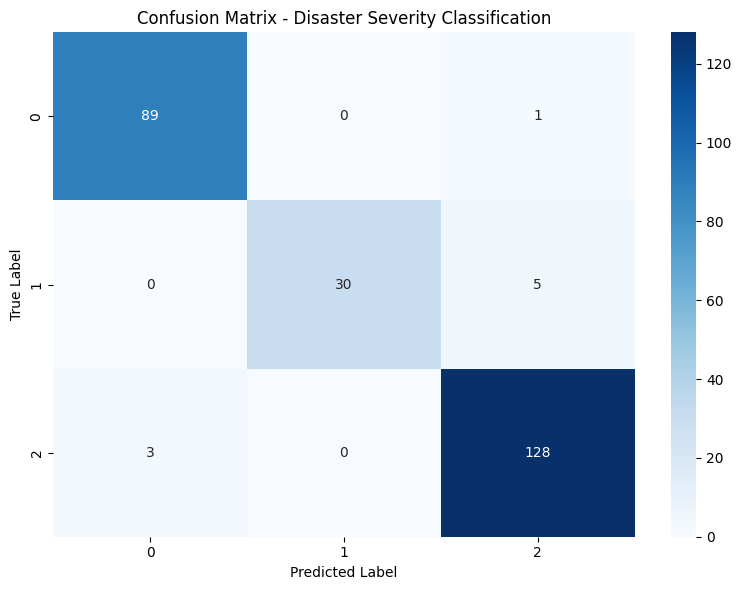

In [128]:
# Sử dụng dữ liệu đã tiền xử lý
severity_labels = create_severity_labels(preprocessed_data['processed_data'])
best_model = train_severity_classification_model(preprocessed_data['features'], severity_labels)

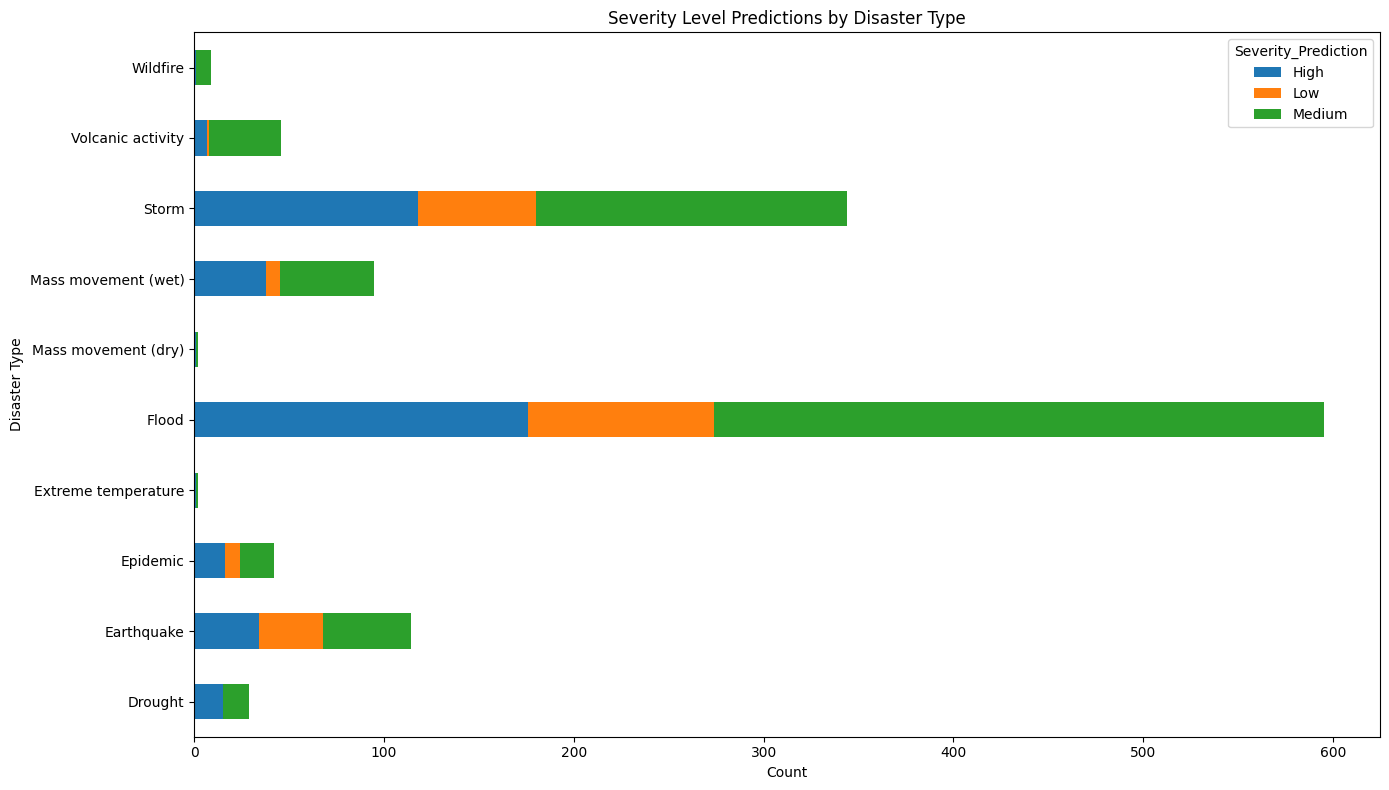

In [129]:
# Dự đoán mức độ nghiêm trọng cho toàn bộ dữ liệu
df_processed = preprocessed_data['processed_data'].copy()
df_processed['Severity_Prediction'] = best_model.predict(preprocessed_data['features'])

# Thêm tên loại thiên tai vào dataframe
df_processed['Disaster_Type'] = df['Disaster Type']

# Nhóm theo loại thiên tai và đếm số lần xuất hiện của từng mức độ nghiêm trọng
severity_counts_by_disaster_type = df_processed.groupby('Disaster_Type')['Severity_Prediction'].value_counts().unstack().fillna(0)

# Trực quan hóa kết quả phân loại theo từng loại thiên tai với biểu đồ thanh ngang
severity_counts_by_disaster_type.plot(kind='barh', stacked=True, figsize=(14, 8))
plt.title('Severity Level Predictions by Disaster Type')
plt.xlabel('Count')
plt.ylabel('Disaster Type')
plt.tight_layout()
plt.show()

